# Unsloth 官网
https://docs.unsloth.ai/get-started/install-and-update/pip-install

**环境**
- RTX5070
- python3.13.9
- torch-2.9.0 + cuda-toolkit-12.8
- cuda-12.9

**cuda-toolkit 安装**

```shell
conda create -n llm_env python==3.13.9
conda activate llm_env
conda install -c "nvidia/label/cuda-12.8.0" cuda-toolkit cuda-nvcc cuda-cudart cuda-driver-dev -y

#检查nvcc
nvcc --version
# 查看nvcc支持的gpu架构是否支持compute_120， RTX5070 是和cuda-12.8搭配需要支持compute_120架构
nvcc --list-gpu-arch 

### 输出
#  compute_50
# compute_52
# compute_53
# compute_60
# compute_61
# compute_62
# compute_70
# compute_72
# compute_75
# compute_80
# compute_86
# compute_87
# compute_89
# compute_90
# compute_100
# compute_101
# compute_120
```

由于是在conda 环境安装 cuda-toolkit 安装到conda env的目录下面， 需要手动把libcuda.so 软连接到/usr/lib 下面， 需要下面的链接操作

```shell
# 检查系统 CUDA 库位置
ldconfig -p | grep libcuda

# 创建符号链接到 conda 环境
mkdir -p /home/wwk/workspace/miniconda3/envs/llm_study/lib64/stubs
ln -s /usr/lib/x86_64-linux-gnu/libcuda.so /home/wwk/workspace/miniconda3/envs/llm_study/lib64/stubs/libcuda.so
ln -s /usr/lib/x86_64-linux-gnu/libcuda.so.1 /home/wwk/workspace/miniconda3/envs/llm_study/lib64/stubs/libcuda.so.1

```


**unsloth 安装**
```shell
pip install unsloth
```

**vllm 安装**
```shell
pip install vllm
```


**unsloth一些路径**
模型默认下载路径(基本使用huggingface的路径)：  ~/.cache/huggingface/hub/

In [2]:
# import os
# import torch
# import subprocess

# # Check current CUDA availability
# print(f"CUDA available: {torch.cuda.is_available()}")
# print(f"CUDA version: {torch.version.cuda}")

# # Find CUDA in conda environment
# conda_prefix = os.environ.get('CONDA_PREFIX')
# if conda_prefix:
#     cuda_paths = [
#         conda_prefix,
#         os.path.join(conda_prefix, 'pkgs', 'cuda-toolkit'),
#     ]
    
#     for path in cuda_paths:
#         nvcc_path = os.path.join(path, 'bin', 'nvcc')
#         if os.path.exists(nvcc_path):
#             os.environ['CUDA_HOME'] = path
#             os.environ['CUDA_ROOT'] = path
#             os.environ['PATH'] = f"{path}/bin:{os.environ['PATH']}"
#             os.environ['LD_LIBRARY_PATH'] = f"{path}/lib:{os.environ.get('LD_LIBRARY_PATH', '')}"
#             print(f"Set CUDA_HOME to: {path}")
#             break
# conda_prefix = os.environ.get('CONDA_PREFIX')
# if conda_prefix:
#     print(f"\nSearching for CUDA in {conda_prefix}...")
#     for root, dirs, files in os.walk(conda_prefix):
#         if 'nvcc' in files or 'libcudart.so' in files:
#             print(f"Found CUDA component in: {root}")

In [ ]:
import os
import torch
import peft
import trl

# 设置支持的 GPU 架构
# 根据你的 GPU 设置正确的架构
os.environ["TORCH_CUDA_ARCH_LIST"] = "8.0;8.6;8.9;9.0"  # 常见架构

# 或者自动检测
if torch.cuda.is_available():
    capability = torch.cuda.get_device_capability()
    arch = f"{capability[0]}.{capability[1]}"
    os.environ["TORCH_CUDA_ARCH_LIST"] = arch
    print(f"Detected GPU architecture: {arch}")

## 如果unsloth 出现flashinfer相关报错， 可以试一下清除 flashinfer 缓存
# import shutil
# cache_dir = os.path.expanduser("~/.cache/flashinfer")
# if os.path.exists(cache_dir):
#     shutil.rmtree(cache_dir)
#     print("Cleared flashinfer cache")

/home/wwk/workspace/miniconda3/envs/llm_study/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Detected GPU architecture: 12.0
Cleared flashinfer cache


In [4]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Can increase for longer reasoning traces
lora_rank = 32 # Larger rank = smarter, but slower
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Qwen3-4B-Base",
    max_seq_length = max_seq_length,
    load_in_4bit = True, # False for LoRA 16bit
    fast_inference = True, # Enable vLLM fast inference
    max_lora_rank = lora_rank,
    gpu_memory_utilization = 0.6 # Reduce if out of memory
)

model = FastLanguageModel.get_peft_model(
    model,
    r = lora_rank, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = [
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ],
    lora_alpha = lora_rank*2, # *2 speeds up training
    use_gradient_checkpointing = "unsloth", # Reduces memory usage
    random_state = 3407,
)


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/tmp/ipykernel_90857/477172518.py:1: UserWarning: WARNING: Unsloth should be imported before trl, transformers, peft to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel


WARNING 11-29 22:38:40 [interface.py:409] Using 'pin_memory=False' as WSL is detected. This may slow down the performance.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 11-29 22:38:47 [vllm_utils.py:702] Unsloth: Patching vLLM v1 graph capture
==((====))==  Unsloth 2025.11.4: Fast Qwen3 patching. Transformers: 4.57.2. vLLM: 0.11.2.
   \\   /|    NVIDIA GeForce RTX 5070 Laptop GPU. Num GPUs = 1. Max memory: 7.96 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu128. CUDA: 12.0. CUDA Toolkit: 12.8. Triton: 3.5.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


'(ProtocolError('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer')), '(Request ID: b72fc53f-70e7-4ebb-8672-a1ad2135d18f)')' thrown while requesting HEAD https://huggingface.co/unslothai/other/resolve/43d9e0f2f19a5d7836895f648dc0e762816acf77/README.md
[huggingface_hub.utils._http|WARNING]'(ProtocolError('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer')), '(Request ID: b72fc53f-70e7-4ebb-8672-a1ad2135d18f)')' thrown while requesting HEAD https://huggingface.co/unslothai/other/resolve/43d9e0f2f19a5d7836895f648dc0e762816acf77/README.md
Retrying in 1s [Retry 1/5].
[huggingface_hub.utils._http|WARNING]Retrying in 1s [Retry 1/5].
'(ProtocolError('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer')), '(Request ID: ffe46314-4bf7-4abd-8e94-ffd56339ae91)')' thrown while requesting HEAD https://huggingface.co/unslothai/other/resolve/43d9e0f2f19a5d7836895f648dc0e762816acf77/model.safetensors
[huggingface_hub.utils._http|WA

Unsloth: vLLM loading unsloth/qwen3-4b-base-unsloth-bnb-4bit with actual GPU utilization = 50.65%
Unsloth: Your GPU has CUDA compute capability 12.0 with VRAM = 7.96 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 2048. Num Sequences = 128.
Unsloth: vLLM's KV Cache can use up to 1.28 GB. Also swap space = 0 GB.
Unsloth: Not an error, but `use_cudagraph` is not supported in vLLM.config.CompilationConfig. Skipping.
WARNING 11-29 22:39:22 [compilation.py:610] Level is deprecated and will be removed in the next release,either 0.12.0 or 0.11.2 whichever is soonest.Use mode instead.If both level and mode are given,only mode will be used.
WARNING 11-29 22:39:22 [compilation.py:699] The 'use_inductor' flag is deprecated and will be removed in the next release (v0.12.0). Please use the 'backend' option instead.
Unsloth: Not an error, but `device` is not supported in vLLM. Skipping.
INFO 11-29 22:39:22 [utils.py:253] non-default args: {'load_format': 'bitsandbytes', 'dtype': 

/home/wwk/workspace/miniconda3/envs/llm_study/lib/python3.13/site-packages/pydantic/type_adapter.py:605: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `enum` - serialized value may not be as expected [field_name='mode', input_value=3, input_type=int])
  return self.serializer.to_python(


INFO 11-29 22:39:28 [model.py:631] Resolved architecture: Qwen3ForCausalLM
INFO 11-29 22:39:28 [model.py:1745] Using max model len 2048


2025-11-29 22:39:28,450	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


INFO 11-29 22:39:28 [scheduler.py:216] Chunked prefill is enabled with max_num_batched_tokens=2048.
Unsloth: vLLM Bitsandbytes config using kwargs = {'load_in_8bit': False, 'load_in_4bit': True, 'bnb_4bit_compute_dtype': 'bfloat16', 'bnb_4bit_quant_storage': 'uint8', 'bnb_4bit_quant_type': 'nf4', 'bnb_4bit_use_double_quant': True, 'llm_int8_enable_fp32_cpu_offload': False, 'llm_int8_has_fp16_weight': False, 'llm_int8_skip_modules': ['lm_head', 'multi_modal_projector', 'merger', 'modality_projection', 'model.layers.0.mlp', 'model.layers.4.mlp', 'model.layers.3.self_attn', 'model.layers.0.self_attn', 'model.layers.6.mlp', 'model.layers.1.self_attn', 'model.layers.1.mlp', 'model.layers.2.mlp'], 'llm_int8_threshold': 6.0}
INFO 11-29 22:39:21 [core.py:93] Initializing a V1 LLM engine (v0.11.2) with config: model='unsloth/qwen3-4b-base-unsloth-bnb-4bit', speculative_config=None, tokenizer='unsloth/qwen3-4b-base-unsloth-bnb-4bit', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None,

/home/wwk/workspace/miniconda3/envs/llm_study/lib/python3.13/site-packages/pydantic/type_adapter.py:605: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `enum` - serialized value may not be as expected [field_name='mode', input_value=3, input_type=int])
  return self.serializer.to_python(


INFO 11-29 22:39:22 [topk_topp_sampler.py:36] Using FlashInfer for top-p & top-k sampling.
INFO 11-29 22:39:22 [gpu_model_runner.py:3259] Starting to load model unsloth/qwen3-4b-base-unsloth-bnb-4bit...
INFO 11-29 22:39:22 [cuda.py:418] Valid backends: ['FLASH_ATTN', 'FLASHINFER', 'TRITON_ATTN', 'FLEX_ATTENTION']
INFO 11-29 22:39:22 [cuda.py:427] Using FLASH_ATTN backend.
INFO 11-29 22:39:23 [bitsandbytes_loader.py:791] Loading weights with BitsAndBytes quantization. May take a while ...
INFO 11-29 22:39:26 [weight_utils.py:441] Time spent downloading weights for unsloth/qwen3-4b-base-unsloth-bnb-4bit: 1.055983 seconds
INFO 11-29 22:39:38 [weight_utils.py:481] No model.safetensors.index.json found in remote.


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [-1:59:49<00:00, -0.09it/s]

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:03<00:00,  3.33s/it]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:03<00:00,  3.33s/it]


INFO 11-29 22:39:31 [punica_selector.py:20] Using PunicaWrapperGPU.


INFO 11-29 22:39:31 [gpu_model_runner.py:3338] Model loading took 3.2439 GiB memory and 8.725790 seconds
INFO 11-29 22:39:54 [backends.py:631] Using cache directory: /home/wwk/.cache/vllm/torch_compile_cache/2b0661a394/rank_0_0/backbone for vLLM's torch.compile
INFO 11-29 22:39:54 [backends.py:647] Dynamo bytecode transform time: 10.66 s
INFO 11-29 22:39:57 [backends.py:210] Directly load the compiled graph(s) for dynamic shape from the cache, took 2.783 s
INFO 11-29 22:39:59 [monitor.py:34] torch.compile takes 13.45 s in total
INFO 11-29 22:40:33 [gpu_worker.py:359] Available KV cache memory: 0.50 GiB
INFO 11-29 22:40:34 [kv_cache_utils.py:1229] GPU KV cache size: 3,648 tokens
INFO 11-29 22:40:34 [kv_cache_utils.py:1234] Maximum concurrency for 2,048 tokens per request: 1.78x


2025-11-29 22:40:34,138 - INFO - autotuner.py:256 - flashinfer.jit: [Autotuner]: Autotuning process starts ...
2025-11-29 22:40:34,515 - INFO - autotuner.py:262 - flashinfer.jit: [Autotuner]: Autotuning process ends


INFO 11-29 22:40:34 [vllm_utils.py:707] Unsloth: Running patched vLLM v1 `capture_model`.


Capturing CUDA graphs (mixed prefill-decode, PIECEWISE):   0%|          | 0/70 [00:00<?, ?it/s]

WARNING 11-29 22:40:35 [utils.py:250] Using default LoRA kernel configs


Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 70/70 [00:02<00:00, 27.34it/s]
Capturing CUDA graphs (decode, FULL): 100%|██████████| 38/38 [00:18<00:00,  2.03it/s]

INFO 11-29 22:40:55 [gpu_model_runner.py:4244] Graph capturing finished in 21 secs, took 1.93 GiB
INFO 11-29 22:40:55 [vllm_utils.py:714] Unsloth: Patched vLLM v1 graph capture finished in 21 secs.


INFO 11-29 22:40:56 [core.py:250] init engine (profile, create kv cache, warmup model) took 85.01 seconds
INFO 11-29 22:41:01 [llm.py:352] Supported tasks: ('generate',)
Unsloth: Just some info: will skip parsing ['attention_norm', 'ffn_norm', 'norm1', 'layer_norm1', 'post_feedforward_layernorm', 'input_layernorm', 'layer_norm2', 'norm2', 'post_layernorm', 'q_norm', 'k_norm', 'norm', 'pre_feedforward_layernorm', 'post_attention_layernorm']
Performing substitution for additional_keys=set()
Unsloth: Just some info: will skip parsing ['cross_attn_post_attention_layernorm', 'attention_norm', 'ffn_norm', 'norm1', 'layer_norm1', 'post_feedforward_layernorm', 'input_layernorm', 'layer_norm2', 'cross_attn_input_layernorm', 'norm2', 'post_layernorm', 'q_norm', 'k_norm', 'norm', 'pre_feedforward_layernorm', 'post_attention_layernorm']


Unsloth 2025.11.4 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


# Chat Template

In [5]:

reasoning_start = "<start_working_out>" # Acts as <think>
reasoning_end   = "<end_working_out>"   # Acts as </think>
solution_start  = "<SOLUTION>"
solution_end    = "</SOLUTION>"

system_prompt = \
f"""You are given a problem.
Think about the problem and provide your working out.
Place it between {reasoning_start} and {reasoning_end}.
Then, provide your solution between {solution_start}{solution_end}"""
# system_prompt

chat_template = \
    "{% if messages[0]['role'] == 'system' %}"\
        "{{ messages[0]['content'] + eos_token }}"\
        "{% set loop_messages = messages[1:] %}"\
    "{% else %}"\
        "{{ '{system_prompt}' + eos_token }}"\
        "{% set loop_messages = messages %}"\
    "{% endif %}"\
    "{% for message in loop_messages %}"\
        "{% if message['role'] == 'user' %}"\
            "{{ message['content'] }}"\
        "{% elif message['role'] == 'assistant' %}"\
            "{{ message['content'] + eos_token }}"\
        "{% endif %}"\
    "{% endfor %}"\
    "{% if add_generation_prompt %}{{ '{reasoning_start}' }}"\
    "{% endif %}"

# Replace with out specific template:
chat_template = chat_template\
    .replace("'{system_prompt}'",   f"'{system_prompt}'")\
    .replace("'{reasoning_start}'", f"'{reasoning_start}'")




In [6]:
tokenizer.chat_template = chat_template
print(tokenizer.chat_template) 


{% if messages[0]['role'] == 'system' %}{{ messages[0]['content'] + eos_token }}{% set loop_messages = messages[1:] %}{% else %}{{ 'You are given a problem.
Think about the problem and provide your working out.
Place it between <start_working_out> and <end_working_out>.
Then, provide your solution between <SOLUTION></SOLUTION>' + eos_token }}{% set loop_messages = messages %}{% endif %}{% for message in loop_messages %}{% if message['role'] == 'user' %}{{ message['content'] }}{% elif message['role'] == 'assistant' %}{{ message['content'] + eos_token }}{% endif %}{% endfor %}{% if add_generation_prompt %}{{ '<start_working_out>' }}{% endif %}


In [7]:
tokenizer.apply_chat_template([
    {"role" : "user", "content" : "What is 1+1?"},
    {"role" : "assistant", "content" : f"{reasoning_start}I think it's 2.{reasoning_end}{solution_start}2{solution_end}"},
    {"role" : "user", "content" : "What is 2+2?"},
], tokenize = False, add_generation_prompt = True)

"You are given a problem.\nThink about the problem and provide your working out.\nPlace it between <start_working_out> and <end_working_out>.\nThen, provide your solution between <SOLUTION></SOLUTION><|endoftext|>What is 1+1?<start_working_out>I think it's 2.<end_working_out><SOLUTION>2</SOLUTION><|endoftext|>What is 2+2?<start_working_out>"

# Get Dataset

In [8]:

from datasets import load_dataset
import pandas as pd
import numpy as np

dataset = load_dataset("unsloth/OpenMathReasoning-mini", split = "cot")
dataset = dataset.to_pandas()[
    ["expected_answer", "problem", "generated_solution"]
]

# Try converting to number - if not, replace with NaN
is_number = pd.to_numeric(pd.Series(dataset["expected_answer"]), errors = "coerce").notnull()
# Select only numbers
dataset = dataset.iloc[np.where(is_number)[0]]

dataset

,expected_answer,problem,generated_solution
0,14,Given $\sqrt{x^2+165}-\sqrt{x^2-52}=7$ and $x$...,"<think>\nOkay, let's see. I need to solve the ..."
6,-2,Find the value of the parameter $a$ for which ...,"<think>\nOkay, so I need to find the value of ..."
9,18,What is the sum of all real numbers $x$ for wh...,"<think>\nOkay, so I need to solve the equation..."
13,2,Evaluate the sum \(\sum_{n=1}^\infty \frac{\ph...,"<think>\nOkay, so I need to evaluate the infin..."
17,30,What is the largest positive integer that divi...,"<think>\nAlright, so I need to find the larges..."
...,...,...,...
19243,244,"Let \( p \), \( q \), and \( r \) be the disti...","<think>\nOkay, so I need to find the value of ..."
19245,1,A bug is on the $0$ of a number line. At any p...,"<think>\nOkay, so I have this problem where a ..."
19247,4,A bus left point X for point Y. Two hours late...,"<think>\nOkay, let's tackle this problem step ..."
19248,18,Each interior angle of a regular n-gon measure...,"<think>\nOkay, let's see. I need to find the n..."


# Data Preprocessing

In [9]:

def format_dataset(x):
    expected_answer = x["expected_answer"]
    problem = x["problem"]

    # Remove generated <think> and </think>
    thoughts = x["generated_solution"]
    thoughts = thoughts.replace("<think>", "").replace("</think>", "")

    # Strip newlines on left and right
    thoughts = thoughts.strip()
    # Add our custom formatting
    final_prompt = \
        reasoning_start + thoughts + reasoning_end + \
        solution_start + expected_answer + solution_end
    # system_prompt = role
    # problem
    # final_prompt = CoT + answer
    return [
        {"role" : "system",    "content" : system_prompt},
        {"role" : "user",      "content" : problem},
        {"role" : "assistant", "content" : final_prompt},
    ]

dataset["Messages"] = dataset.apply(format_dataset, axis = 1)
tokenizer.apply_chat_template(dataset["Messages"][0], tokenize = False)


"You are given a problem.\nThink about the problem and provide your working out.\nPlace it between <start_working_out> and <end_working_out>.\nThen, provide your solution between <SOLUTION></SOLUTION><|endoftext|>Given $\\sqrt{x^2+165}-\\sqrt{x^2-52}=7$ and $x$ is positive, find all possible values of $x$.<start_working_out>Okay, let's see. I need to solve the equation √(x² + 165) - √(x² - 52) = 7, and find all positive values of x. Hmm, radicals can be tricky, but maybe if I can eliminate the square roots by squaring both sides. Let me try that.\n\nFirst, let me write down the equation again to make sure I have it right:\n\n√(x² + 165) - √(x² - 52) = 7.\n\nOkay, so the idea is to isolate one of the radicals and then square both sides. Let me try moving the second radical to the other side:\n\n√(x² + 165) = 7 + √(x² - 52).\n\nNow, if I square both sides, maybe I can get rid of the square roots. Let's do that:\n\n(√(x² + 165))² = (7 + √(x² - 52))².\n\nSimplifying the left side:\n\nx² + 

In [10]:

dataset["N"] = dataset["Messages"].apply(lambda x: len(tokenizer.apply_chat_template(x)))
dataset = dataset.loc[dataset["N"] <= max_seq_length/2].copy()
print(dataset.shape)


from datasets import Dataset

dataset["text"] = tokenizer.apply_chat_template(dataset["Messages"].values.tolist(), tokenize = False)
dataset = Dataset.from_pandas(dataset)
dataset

(59, 5)


Dataset({
    features: ['expected_answer', 'problem', 'generated_solution', 'Messages', 'N', 'text', '__index_level_0__'],
    num_rows: 59
})

# SFT Training


In [11]:
from unsloth import is_bfloat16_supported
from trl import SFTTrainer, SFTConfig
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    args = SFTConfig(
        dataset_text_field = "text",
        per_device_train_batch_size = 1,
        bf16 = is_bfloat16_supported(),
        fp16 = not is_bfloat16_supported(),
        gradient_accumulation_steps = 2, # Use GA to mimic batch size!
        warmup_steps = 5,
        num_train_epochs = 2, # Set this for 1 full training run.
        learning_rate = 2e-4, # Reduce to 2e-5 for long training runs
        logging_steps = 5,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        # 添加内存相关参数
        dataloader_pin_memory=False,
        remove_unused_columns=False,
        max_seq_length=1024,  # 添加序列长度
        seed = 3407,
        report_to = "none", # Use this for WandB etc
    ),
)
trainer.train()


True
NVIDIA GeForce RTX 5070 Laptop GPU


Unsloth: Tokenizing ["text"] (num_proc=36): 100%|██████████| 59/59 [00:08<00:00,  6.72 examples/s]
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 59 | Num Epochs = 2 | Total steps = 60
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 2 x 1) = 2
 "-____-"     Trainable parameters = 66,060,288 of 4,088,528,384 (1.62% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
5,0.746900
10,0.499300
15,0.468900
20,0.466800
25,0.406500
30,0.449000
35,0.312700
40,0.292400
45,0.291100
50,0.261100


TrainOutput(global_step=60, training_loss=0.39601008892059325, metrics={'train_runtime': 136.0745, 'train_samples_per_second': 0.867, 'train_steps_per_second': 0.441, 'total_flos': 1353455198164992.0, 'train_loss': 0.39601008892059325, 'epoch': 2.0})

In [14]:
help(model)

Help on PeftModelForCausalLM in module peft.peft_model object:

class PeftModelForCausalLM(PeftModel)
 |  PeftModelForCausalLM(
 |      model: 'torch.nn.Module',
 |      peft_config: 'PeftConfig',
 |      adapter_name: 'str' = 'default',
 |      **kwargs
 |  ) -> 'None'
 |
 |  Peft model for causal language modeling.
 |
 |  Args:
 |      model ([`~transformers.PreTrainedModel`]): Base transformer model.
 |      peft_config ([`PeftConfig`]): Peft config.
 |      adapter_name (`str`,  *optional*): The name of the adapter, defaults to `"default"`.
 |      autocast_adapter_dtype (`bool`, *optional*):
 |          Whether to autocast the adapter dtype. Defaults to `True`. Right now, this will only cast adapter weights
 |          using float16 and bfloat16 to float32, as this is typically required for stable training, and only affect
 |          select PEFT tuners.
 |
 |  Example:
 |
 |      ```py
 |      >>> from transformers import AutoModelForCausalLM
 |      >>> from peft import PeftMode

In [20]:
sample=None
for v in dataset:
    print(v.keys())
    print( v['problem'], v['expected_answer'], v['text'])
    sample = v
    break

dict_keys(['expected_answer', 'problem', 'generated_solution', 'Messages', 'N', 'text', '__index_level_0__'])
Jenifer has 82 cents in pennies and nickels. Her younger brother mistook all her nickels for dimes and counted the total as $1.47. How many pennies does Jenifer have? 17 You are given a problem.
Think about the problem and provide your working out.
Place it between <start_working_out> and <end_working_out>.
Then, provide your solution between <SOLUTION></SOLUTION><|endoftext|>Jenifer has 82 cents in pennies and nickels. Her younger brother mistook all her nickels for dimes and counted the total as $1.47. How many pennies does Jenifer have?<start_working_out>Okay, let's see. So the problem is about Jenifer who has 82 cents in pennies and nickels. But her younger brother thought all the nickels were dimes and counted the total as $1.47. We need to find out how many pennies Jenifer has. Hmm, let's break this down step by step.

First, let me note down what we know. Let me denote t

In [32]:

#预处理一个样本 给模型推理， 最长token数=1024
text = tokenizer.apply_chat_template(
    dataset[0]["Messages"][:2], # Message 是 list 包括system_prompt, question, assistent_correct_answer. [:2]只取systemm_prompt, question
    tokenize = False,
    add_generation_prompt = True, # Must add for generation
)

from transformers import TextStreamer
_ = model.generate(
    **tokenizer(text, return_tensors = "pt").to("cuda"),
    temperature = 0,
    max_new_tokens = 1024,
    streamer = TextStreamer(tokenizer, skip_prompt = False), # 加入打字机效果
)

You are given a problem.
Think about the problem and provide your working out.
Place it between <start_working_out> and <end_working_out>.
Then, provide your solution between <SOLUTION></SOLUTION><|endoftext|>Jenifer has 82 cents in pennies and nickels. Her younger brother mistook all her nickels for dimes and counted the total as $1.47. How many pennies does Jenifer 

have?<start_working_out>Okay, let's see. Jenifer has 82 cents in pennies and nickels. Her brother thought all the nickels were dimes and counted the total as $1.47. I need to find out how many pennies she has. Hmm, let me break this down.

First, I need to set up some equations. Let's say the number of pennies is P and the number of nickels is N. The total value of the coins is 82 cents. So, the equation for the total value would be:

1P + 5N = 82

Because each penny is worth 1 cent and each nickel is worth 5 cents.

Now, her brother mistook all the nickels for dimes. Dimes are worth 10 cents each. So, if he counted all the nickels as dimes, the total would be $1.47, which is 147 cents. So the equation for that would be:

1P + 10N = 147

Because the number of pennies is the same, but the nickels are now counted as dimes.

Now I have two equations:

1. P + 5N = 82
2. P + 10N = 147

I can solve these equations to find P and N. Let me subtract the first equation from the second to elimina

In [ ]:
# 正确答案
dataset[0]["Messages"][2]  

{'content': "<start_working_out>Okay, let's see. So the problem is about Jenifer who has 82 cents in pennies and nickels. But her younger brother thought all the nickels were dimes and counted the total as $1.47. We need to find out how many pennies Jenifer has. Hmm, let's break this down step by step.\n\nFirst, let me note down what we know. Let me denote the number of pennies as P and the number of nickels as N. Since pennies are worth 1 cent each and nickels 5 cents, the total value Jenifer has is 1*P + 5*N = 82 cents. That's the first equation.\n\nNow, her brother mistook nickels for dimes. Dimes are 10 cents each, right? So he counted the nickels as dimes. So the total he thought she had would be P*1 + N*10 = 147 cents (because $1.47 is 147 cents). So that's the second equation: P + 10N = 147.\n\nSo now we have two equations:\n\n1) P + 5N = 82\n2) P + 10N = 147\n\nWe can solve this system of equations to find P and N. Let me think, subtract the first equation from the second to el

# GRPO Training

### 1. 数据集准备：使用GRPO 带reward的数据集

In [34]:

from datasets import load_dataset
rl_dataset = load_dataset("open-r1/DAPO-Math-17k-Processed", "en", split = "train")
rl_dataset

Generating train split: 100%|██████████| 14116/14116 [00:00<00:00, 227113.97 examples/s]


Dataset({
    features: ['prompt', 'solution', 'data_source', 'source_prompt', 'ability', 'reward_model', 'extra_info'],
    num_rows: 14116
})

In [37]:
rl_dataset[0]

{'prompt': 'In triangle $ABC$, $\\sin \\angle A = \\frac{4}{5}$ and $\\angle A < 90^\\circ$. Let $D$ be a point outside triangle $ABC$ such that $\\angle BAD = \\angle DAC$ and $\\angle BDC = 90^\\circ$. Suppose that $AD = 1$ and that $\\frac{BD}{CD} = \\frac{3}{2}$. If $AB + AC$ can be expressed in the form $\\frac{a\\sqrt{b}}{c}$ where $a, b, c$ are pairwise relatively prime integers, find $a + b + c$.',
 'solution': '34',
 'data_source': 'math_dapo',
 'source_prompt': [{'content': 'Solve the following math problem step by step. The last line of your response should be of the form Answer: $Answer (without quotes) where $Answer is the answer to the problem.\n\nIn triangle $ABC$, $\\sin \\angle A = \\frac{4}{5}$ and $\\angle A < 90^\\circ$. Let $D$ be a point outside triangle $ABC$ such that $\\angle BAD = \\angle DAC$ and $\\angle BDC = 90^\\circ$. Suppose that $AD = 1$ and that $\\frac{BD}{CD} = \\frac{3}{2}$. If $AB + AC$ can be expressed in the form $\\frac{a\\sqrt{b}}{c}$ where $a

In [ ]:

reasoning_start = "<start_working_out>" # Acts as <think>
reasoning_end   = "<end_working_out>"   # Acts as </think>
solution_start  = "<SOLUTION>"
solution_end    = "</SOLUTION>"

system_prompt = \
f"""You are given a problem.
Think about the problem step-by-step and provide your working out in a list to show the solution clearly and precisely.
Place it between {reasoning_start} and {reasoning_end}.
Then, provide your solution between {solution_start}{solution_end}"""

def extract_hash_answer(text):
    # if "####" not in text: return None
    # return text.split("####")[1].strip()
    return text
# extract_hash_answer(dataset[0]["solution"])

rl_dataset = rl_dataset.map(lambda x: {
    "prompt" : [
        {"role": "system", "content": system_prompt},
        {"role": "user",   "content": x["prompt"]},
    ],
    "answer": extract_hash_answer(x["solution"]),
})
rl_dataset[0]

Map: 100%|██████████| 14116/14116 [00:00<00:00, 22128.27 examples/s]


{'prompt': [{'content': 'You are given a problem.\nThink about the problem step-by-step and provide your working out in a list to show the solution clearly and precisely.\nPlace it between <start_working_out> and <end_working_out>.\nThen, provide your solution between <SOLUTION></SOLUTION>',
   'role': 'system'},
  {'content': 'In triangle $ABC$, $\\sin \\angle A = \\frac{4}{5}$ and $\\angle A < 90^\\circ$. Let $D$ be a point outside triangle $ABC$ such that $\\angle BAD = \\angle DAC$ and $\\angle BDC = 90^\\circ$. Suppose that $AD = 1$ and that $\\frac{BD}{CD} = \\frac{3}{2}$. If $AB + AC$ can be expressed in the form $\\frac{a\\sqrt{b}}{c}$ where $a, b, c$ are pairwise relatively prime integers, find $a + b + c$.',
   'role': 'user'}],
 'solution': '34',
 'data_source': 'math_dapo',
 'source_prompt': [{'content': 'Solve the following math problem step by step. The last line of your response should be of the form Answer: $Answer (without quotes) where $Answer is the answer to the pro

### 2. 设计reward函数

In [45]:
import re

# Add optional EOS token matching
solution_end_regex = r"</SOLUTION>[\s]{0,}" + \
    "(?:" + re.escape(tokenizer.eos_token) + ")?"

match_format = re.compile(
    rf"{reasoning_end}.*?"\
    rf"{solution_start}(.+?){solution_end_regex}"\
    rf"[\s]{{0,}}$",
    flags = re.MULTILINE | re.DOTALL
)
##match_format
def match_format_exactly(completions, **kwargs):
    scores = []
    for completion in completions:
        score = 0
        response = completion[0]["content"]
        # Match if format is seen exactly!
        if match_format.search(response) is not None: score += 3.0
        scores.append(score)
    return scores

def match_format_approximately(completions, **kwargs):
    scores = []
    for completion in completions:
        score = 0
        response = completion[0]["content"]
        # Count how many keywords are seen - we penalize if too many!
        # If we see 1, then plus some points!

        # No need to reward <start_working_out> since we always prepend it!
        # score += 0.5 if response.count(reasoning_start) == 1 else -1.0
        score += 0.5 if response.count(reasoning_end)   == 1 else -1.0
        score += 0.5 if response.count(solution_start)  == 1 else -1.0
        score += 0.5 if response.count(solution_end)    == 1 else -1.0
        scores.append(score)
    return scores




def check_answer(prompts, completions, answer, **kwargs):
    question = prompts[0][-1]["content"]
    responses = [completion[0]["content"] for completion in completions]

    extracted_responses = [
        guess.group(1)
        if (guess := match_format.search(r)) is not None else None \
        for r in responses
    ]

    scores = []
    for guess, true_answer in zip(extracted_responses, answer):
        score = 0
        if guess is None:
            scores.append(-2.0)
            continue
        # Correct answer gets 5 points!
        if guess == true_answer:
            score += 5.0
        # Match if spaces are seen, but less reward
        elif guess.strip() == true_answer.strip():
            score += 3.5
        else:
            # We also reward it if the answer is close via ratios!
            # Ie if the answer is within some range, reward it!
            try:
                ratio = float(guess) / float(true_answer)
                if   ratio >= 0.9 and ratio <= 1.1: score += 2.0
                elif ratio >= 0.8 and ratio <= 1.2: score += 1.5
                else: score -= 2.5 # Penalize wrong answers
            except:
                score -= 4.5 # Penalize
        scores.append(score)
    return scores


In [47]:
global PRINTED_TIMES
PRINTED_TIMES = 0
global PRINT_EVERY_STEPS
PRINT_EVERY_STEPS = 5

match_numbers = re.compile(
    solution_start + r".*?[\s]{0,}([-]?[\d\.\,]{1,})",
    flags = re.MULTILINE | re.DOTALL
)
print(match_numbers.findall("<SOLUTION>  0.34  </SOLUTION>"))
print(match_numbers.findall("<SOLUTION>  123,456  </SOLUTION>"))
print(match_numbers.findall("<SOLUTION>  -0.234  </SOLUTION>"))
print(match_numbers.findall("<SOLUTION>17</SOLUTION>"))

def check_numbers(prompts, completions, answer, **kwargs):
    question = prompts[0][-1]["content"]
    responses = [completion[0]["content"] for completion in completions]

    
    extracted_responses = [
        guess.group(1)
        if (guess := match_numbers.search(r)) is not None else None \
        for r in responses
    ]

    scores = []
    # Print only every few steps
    global PRINTED_TIMES
    global PRINT_EVERY_STEPS
    if PRINTED_TIMES % PRINT_EVERY_STEPS == 0:
        print(
            '*'*20 + f"Question:\n{question}", f"\nAnswer:\n{answer[0]}", f"\nResponse:\n{responses[0]}", f"\nExtracted:\n{extracted_responses[0]}"
        )
    PRINTED_TIMES += 1

    for guess, true_answer in zip(extracted_responses, answer):
        if guess is None:
            scores.append(-2.5)
            continue
        # Convert to numbers
        try:
            true_answer = float(true_answer.strip())
            # Remove commas like in 123,456
            guess       = float(guess.strip().replace(",", ""))
            scores.append(3.5 if guess == true_answer else -1.5)
        except:
            scores.append(0)
            continue
    return scores

['0.34']
['123,456']
['-0.234']
['17']


In [41]:
# 调用上面的system_prompt的提示词后，再tokenizer 输出tokens ids 以及batching
tokenized = rl_dataset.map(
    lambda x: {"tokens" : tokenizer.apply_chat_template(x["prompt"], add_generation_prompt = True, tokenize = True)},
    batched = True,
)
print("tokenized[0]: ", tokenized[0])
print(tokenizer.decode(tokenized[0]["tokens"]))
tokenized = tokenized.map(lambda x: {"L" : len(x["tokens"])})

import numpy as np
maximum_length = int(np.quantile(tokenized["L"], 0.9))
print("Max Length = ", maximum_length)

# Filter only samples smaller than 90% max length
rl_dataset = rl_dataset.select(np.where(np.array(tokenized["L"]) <= maximum_length)[0])
del tokenized

Map: 100%|██████████| 14116/14116 [00:03<00:00, 4178.19 examples/s]


tokenized[0]:  {'prompt': [{'content': 'You are given a problem.\nThink about the problem step-by-step and provide your working out in a list to show the solution clearly and precisely.\nPlace it between <start_working_out> and <end_working_out>.\nThen, provide your solution between <SOLUTION></SOLUTION>', 'role': 'system'}, {'content': 'In triangle $ABC$, $\\sin \\angle A = \\frac{4}{5}$ and $\\angle A < 90^\\circ$. Let $D$ be a point outside triangle $ABC$ such that $\\angle BAD = \\angle DAC$ and $\\angle BDC = 90^\\circ$. Suppose that $AD = 1$ and that $\\frac{BD}{CD} = \\frac{3}{2}$. If $AB + AC$ can be expressed in the form $\\frac{a\\sqrt{b}}{c}$ where $a, b, c$ are pairwise relatively prime integers, find $a + b + c$.', 'role': 'user'}], 'solution': '34', 'data_source': 'math_dapo', 'source_prompt': [{'content': 'Solve the following math problem step by step. The last line of your response should be of the form Answer: $Answer (without quotes) where $Answer is the answer to the

Map: 100%|██████████| 14116/14116 [-1:59:50<00:00, -1404.91 examples/s]

Max Length =  214


In [42]:
rl_dataset

Dataset({
    features: ['prompt', 'solution', 'data_source', 'source_prompt', 'ability', 'reward_model', 'extra_info', 'answer'],
    num_rows: 12709
})

### 3. GRPO RLHF training

In [43]:
from unsloth import is_bfloat16_supported
from vllm import SamplingParams
from trl import GRPOConfig, GRPOTrainer

max_prompt_length = maximum_length + 1 # + 1 just in case!
max_completion_length = max_seq_length - max_prompt_length

vllm_sampling_params = SamplingParams(
    min_p = 0.1,
    top_p = 1.0,
    top_k = -1,
    seed = 3407,
    stop = [tokenizer.eos_token],
    include_stop_str_in_output = True,
)

training_args = GRPOConfig(
    vllm_sampling_params = vllm_sampling_params,
    temperature = 1.0,
    learning_rate = 5e-6,
    weight_decay = 0.05,
    warmup_ratio = 0.1,
    lr_scheduler_type = "linear",
    optim = "adamw_8bit",
    logging_steps = 1,
    per_device_train_batch_size = 1,
    bf16 = is_bfloat16_supported(),
    fp16 = not is_bfloat16_supported(),
    gradient_accumulation_steps = 4, # Increase to 4 for smoother training
    num_generations = 4, # Decrease if out of memory
    max_prompt_length = max_prompt_length,
    max_completion_length = max_completion_length,
    num_train_epochs = 1, # Set to 1 for a full training run
    # max_steps = 100,
    # save_steps = 100,
    max_steps = 30,
    save_steps = 30,
    report_to = "none", # Can use Weights & Biases
    output_dir = "outputs",

    generation_kwargs={
        # "max_new_tokens": 128,
        "top_p": 0.9,
    },
    # For optional training + evaluation
    # fp16_full_eval = True,
    # per_device_eval_batch_size = 4,
    # eval_accumulation_steps = 1,
    # eval_strategy = "steps",
    # eval_steps = 1,
)

In [48]:

# For optional training + evaluation
# new_dataset = dataset.train_test_split(test_size = 0.01)

rl_trainer = GRPOTrainer(
    model = model,
    processing_class = tokenizer,
    reward_funcs = [
        match_format_exactly,
        match_format_approximately,
        check_answer,
        check_numbers,
    ],
    args = training_args,
    train_dataset = rl_dataset,

    # For optional training + evaluation
    # train_dataset = new_dataset["train"],
    # eval_dataset = new_dataset["test"],
)
rl_trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 12,709 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 4 x 1) = 4
 "-____-"     Trainable parameters = 66,060,288 of 4,088,528,384 (1.62% trained)


********************Question:
Compute the number of positive integers that divide at least two of the integers in the set $\{1^1,2^2,3^3,4^4,5^5,6^6,7^7,8^8,9^9,10^{10}\}$. 
Answer:
22 
Response:
Okay, so I need to find the number of positive integers that divide at least two of the numbers in the set {1^1, 2^2, 3^3, 4^4, 5^5, 6^6, 7^7, 8^8, 9^9, 10^10}. Hmm, let's start by understanding the problem. I need to find all the divisors of at least two different numbers in this set. So, maybe I can think of the divisors of each number and then find the common divisors between at least two of them. But since the exponents are high, some of these numbers are very large, and their divisors would be quite big. But the question is about the number of such divisors, not the divisors themselves. So maybe I can use the concept of the greatest common divisor (GCD) and the fact that a number is a common divisor of two numbers if and only if it divides their GCD. But since the question is about at lea

Step,Training Loss,reward,reward_std,completions / mean_length,completions / min_length,completions / max_length,completions / clipped_ratio,completions / mean_terminated_length,completions / min_terminated_length,completions / max_terminated_length,sampling / sampling_logp_difference / mean,sampling / sampling_logp_difference / max,sampling / importance_sampling_ratio / min,sampling / importance_sampling_ratio / mean,sampling / importance_sampling_ratio / max,kl,rewards / match_format_exactly / mean,rewards / match_format_exactly / std,rewards / match_format_approximately / mean,rewards / match_format_approximately / std,rewards / check_answer / mean,rewards / check_answer / std,rewards / check_numbers / mean,rewards / check_numbers / std
1,0.000100,-7.500000,0.000000,1833.000000,1833.000000,1833.000000,1.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0.098384,0.000000,0.000000,-3.000000,0.000000,-2.000000,0.000000,-2.500000,0.000000
2,0.000100,-3.500000,4.618802,1649.500000,1443.000000,1833.000000,0.500000,1466.000000,1443.000000,1489.000000,No Log,No Log,No Log,No Log,No Log,0.118224,1.500000,1.732051,-0.750000,2.598076,-2.250000,0.288675,-2.000000,0.577350
3,0.000100,-7.500000,0.000000,1833.000000,1833.000000,1833.000000,1.000000,0.000000,0.000000,0.000000,No Log,No Log,No Log,No Log,No Log,0.096776,0.000000,0.000000,-3.000000,0.000000,-2.000000,0.000000,-2.500000,0.000000
4,0.000100,-7.500000,0.000000,1833.000000,1833.000000,1833.000000,1.000000,0.000000,0.000000,0.000000,No Log,No Log,No Log,No Log,No Log,0.121139,0.000000,0.000000,-3.000000,0.000000,-2.000000,0.000000,-2.500000,0.000000
5,0.000100,-7.500000,0.000000,1833.000000,1833.000000,1833.000000,1.000000,0.000000,0.000000,0.000000,No Log,No Log,No Log,No Log,No Log,0.130537,0.000000,0.000000,-3.000000,0.000000,-2.000000,0.000000,-2.500000,0.000000
6,0.000100,-7.500000,0.000000,1833.000000,1833.000000,1833.000000,1.000000,0.000000,0.000000,0.000000,No Log,No Log,No Log,No Log,No Log,0.096383,0.000000,0.000000,-3.000000,0.000000,-2.000000,0.000000,-2.500000,0.000000
7,0.000100,-3.500000,4.618802,1652.500000,1342.000000,1833.000000,0.500000,1472.000000,1342.000000,1602.000000,No Log,No Log,No Log,No Log,No Log,0.117091,1.500000,1.732051,-0.750000,2.598076,-2.250000,0.288675,-2.000000,0.577350
8,0.000100,-7.500000,0.000000,1833.000000,1833.000000,1833.000000,1.000000,0.000000,0.000000,0.000000,No Log,No Log,No Log,No Log,No Log,0.081524,0.000000,0.000000,-3.000000,0.000000,-2.000000,0.000000,-2.500000,0.000000
9,0.000100,-7.500000,0.000000,1833.000000,1833.000000,1833.000000,1.000000,0.000000,0.000000,0.000000,No Log,No Log,No Log,No Log,No Log,0.076354,0.000000,0.000000,-3.000000,0.000000,-2.000000,0.000000,-2.500000,0.000000
10,0.000100,-7.500000,0.000000,1833.000000,1833.000000,1833.000000,1.000000,0.000000,0.000000,0.000000,No Log,No Log,No Log,No Log,No Log,0.096229,0.000000,0.000000,-3.000000,0.000000,-2.000000,0.000000,-2.500000,0.000000


********************Question:
The sum of $\lfloor x \rfloor$ for all real numbers $x$ satisfying the equation $16 + 15x + 15x^2 = \lfloor x \rfloor^3$ is: 
Answer:
33 
Response:
Okay, so I need to find the sum of the floor of x, denoted as ⌊x⌋, for all real numbers x that satisfy the equation 16 + 15x + 15x² = ⌊x⌋³. Hmm, let's break this down.

First, I need to find all real x where the left side, 16 + 15x + 15x², equals the cube of the floor of x. The floor function, ⌊x⌋, gives the greatest integer less than or equal to x. So, for each possible integer k, I can set ⌊x⌋ = k and then solve the equation 16 + 15x + 15x² = k³. But then, the solution x must also satisfy k ≤ x < k+1. So, for each k, I need to find the roots of the equation 15x² + 15x + 16 - k³ = 0, and then check if the solution x is in the interval [k, k+1).

Let me start by trying some integer values for k. Since the equation is a quadratic in x, the solutions will be x = [ -15 ± sqrt(15² - 4*15*(16 - k³)) ] / (2*15) = [ -

TrainOutput(global_step=30, training_loss=0.00010830584700064113, metrics={'train_runtime': 12864.0568, 'train_samples_per_second': 0.009, 'train_steps_per_second': 0.002, 'total_flos': 0.0, 'train_loss': 0.00010830584700064113})

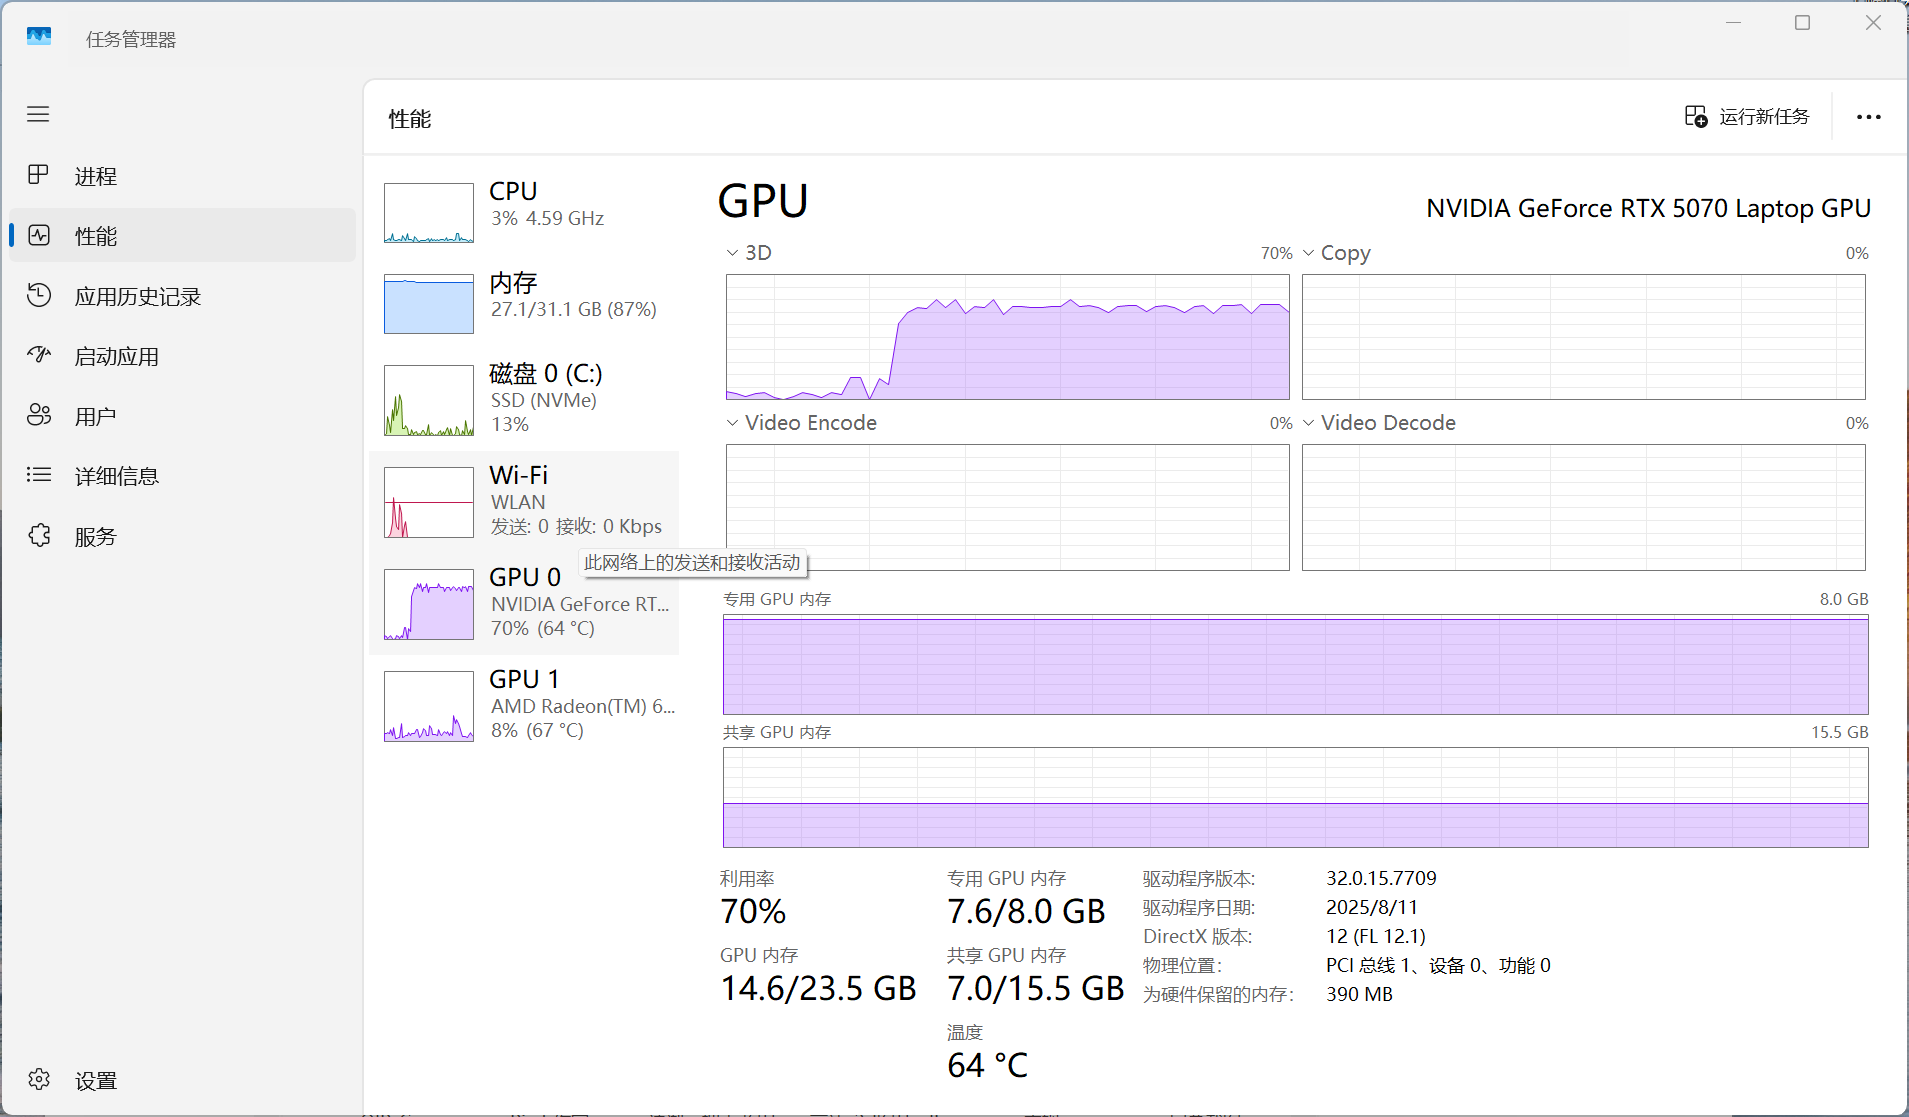

In [49]:
#推理

text = "What is the sqrt of 101?"

from vllm import SamplingParams
sampling_params = SamplingParams(
    temperature = 1.0,
    top_k = 50,
    max_tokens = 1024,
)
output = model.fast_generate(
    [text],
    sampling_params = sampling_params,
    lora_request = None,
)[0].outputs[0].text

output

Processed prompts: 100%|██████████| 1/1 [00:23<00:00, 23.10s/it, est. speed input: 0.43 toks/s, output: 44.33 toks/s]


' - Answers\nAlgebra\nWhat is the sqrt of 101?\nWiki User\n∙ 2007-02-01 00:00:00\nSee answers (2)\nBest Answer\nCopy\n10.049875621120890000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

仅保留lora 微调后参数

In [50]:
model.save_lora("grpo_saved_lora")
from safetensors import safe_open

tensors = {}
with safe_open("grpo_saved_lora/adapter_model.safetensors", framework = "pt") as f:
    # Verify both A and B are non zero
    for key in f.keys():
        tensor = f.get_tensor(key)
        n_zeros = (tensor == 0).sum() / tensor.numel()
        assert(n_zeros.item() != tensor.numel())

In [ ]:
#test loaded lora
messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user",   "content": "What is the sqrt of 101?"},
]

text = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt = True, # Must add for generation
    tokenize = False,
)
from vllm import SamplingParams
sampling_params = SamplingParams(
    temperature = 1.0,
    top_k = 50,
    max_tokens = 2048,
)
output = model.fast_generate(
    text,
    sampling_params = sampling_params,
    lora_request = model.load_lora("grpo_saved_lora"),
)[0].outputs[0].text

output

Processed prompts: 100%|██████████| 1/1 [00:50<00:00, 51.00s/it, est. speed input: 1.39 toks/s, output: 38.77 toks/s]


"Okay, so I need to find the square root of 101. Hmm, let's see. I know that the square root of a number is a value that, when multiplied by itself, gives the original number. But 101 is a bit trickier because it's not a perfect square. \n\nFirst, I should think of the perfect squares around 101. The square of 10 is 100, and the square of 11 is 121. So, the square root of 101 must be between 10 and 11. That's a good start. But I need a more precise value. \n\nSince 101 is between 100 and 121, the square root of 101 is between 10 and 11. To get a better estimate, maybe I can use a method like the average of 10 and 11, and then check. Let's try 10.05. If I square 10.05, that's 10.05 * 10.05. Let me calculate that. 10*10=100, 0.05*0.05=0.0025, and 10*0.05*2=0.1. So, 100 + 0.1 = 100.1, then add 0.0025, which is 100.1025. That's a bit more than 101. So, 10.05 is too high. \n\nNext, try 10.03. Let's square 10.03. 10*10=100, 0.03*0.03=0.0009, 10*0.03*2=0.06. So, 100 + 0.06 = 100.06, add 0.000

# Inference with vLLM in GGUF format

**GGUF 格式**

下面代码我们将torch的safetensors checkpoint文件转成gguf 加快模型推理加速。那什么是GGUF文件呢？

GGUF（GPT-Generated Unified Format）是一种专为高效部署和推理大语言模型而设计的二进制文件格式，由 llama.cpp 项目的创始人 Georgi Gerganov 提出，是 GGML 格式的继任者 。
✅ GGUF 的核心特点：
单文件打包
GGUF 将模型的权重、分词器、超参数、提示模板等所有元数据打包进一个 .gguf 文件中，部署时无需额外配置文件，极大简化了模型分发与使用 。
支持量化
GGUF 原生支持多种量化方式（如 Q4_K_M、Q5_1、Q8_0 等），可以将模型体积从十几 GB 压缩到几 GB，适合在消费级硬件上运行 。
跨平台兼容性强
GGUF 格式被设计为跨平台通用，支持 Windows、Linux、macOS，甚至可以在手机或边缘设备上运行，适配 CPU、CUDA、Metal、Vulkan 等多种后端 。
加载快、推理效率高
GGUF 使用内存映射（mmap）技术，支持快速加载模型，特别适合本地推理场景 。
可扩展性强
GGUF 使用键值对结构存储元数据，支持在不破坏兼容性的前提下添加新信息，具备良好的未来适应性 。






In [ ]:
# !pwd
# !cd ../ && git clone https://github.com/ggerganov/llama.cpp.git
# !cd ../llama.cpp/ && python -m pip install -r requirements.txt
#! cd ../llama.cpp/ && python convert.py --model ./path_to_your_model_directory --outfile ./path_to_your_model.gguf --quantize q4_k_m

/home/wwk/workspace/ai_project/AlgorithmCodingPractice/SFT


In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 1024 # Can increase for longer reasoning traces
lora_rank = 32 # Larger rank = smarter, but slower
# model, tokenizer = FastLanguageModel.from_pretrained(
#     model_name = "unsloth/Qwen3-4B-Base",
#     max_seq_length = max_seq_length,
#     device_map = "cpu",  # 强制使用CPU
#     dtype = torch.float16,  # CPU上使用float16
#     load_in_4bit = False, # False for LoRA 16bit when merging model and LoRA
#     fast_inference = False, # Enable vLLM fast inference
#     gpu_memory_utilization = 0.6, # Reduce if out of memory
# )


model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Qwen3-4B-Base",
    max_seq_length = max_seq_length,
    load_in_4bit = True, # False for LoRA 16bit
    fast_inference = True, # Enable vLLM fast inference
    max_lora_rank = lora_rank,
    gpu_memory_utilization = 0.6 # Reduce if out of memory
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/home/wwk/workspace/miniconda3/envs/llm_study/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


WARNING 11-30 17:16:11 [interface.py:409] Using 'pin_memory=False' as WSL is detected. This may slow down the performance.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 11-30 17:16:19 [vllm_utils.py:702] Unsloth: Patching vLLM v1 graph capture
==((====))==  Unsloth 2025.11.4: Fast Qwen3 patching. Transformers: 4.57.2. vLLM: 0.11.2.
   \\   /|    NVIDIA GeForce RTX 5070 Laptop GPU. Num GPUs = 1. Max memory: 7.96 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu128. CUDA: 12.0. CUDA Toolkit: 12.8. Triton: 3.5.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/qwen3-4b-base-unsloth-bnb-4bit with actual GPU utilization = 50.65%
Unsloth: Your GPU has CUDA compute capability 12.0 with VRAM = 7.96 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 102

/home/wwk/workspace/miniconda3/envs/llm_study/lib/python3.13/site-packages/pydantic/type_adapter.py:605: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `enum` - serialized value may not be as expected [field_name='mode', input_value=3, input_type=int])
  return self.serializer.to_python(


INFO 11-30 17:16:51 [model.py:631] Resolved architecture: Qwen3ForCausalLM
INFO 11-30 17:16:51 [model.py:1745] Using max model len 1024


2025-11-30 17:16:51,764	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


INFO 11-30 17:16:51 [scheduler.py:216] Chunked prefill is enabled with max_num_batched_tokens=2048.
Unsloth: vLLM Bitsandbytes config using kwargs = {'load_in_8bit': False, 'load_in_4bit': True, 'bnb_4bit_compute_dtype': 'bfloat16', 'bnb_4bit_quant_storage': 'uint8', 'bnb_4bit_quant_type': 'nf4', 'bnb_4bit_use_double_quant': True, 'llm_int8_enable_fp32_cpu_offload': False, 'llm_int8_has_fp16_weight': False, 'llm_int8_skip_modules': ['lm_head', 'multi_modal_projector', 'merger', 'modality_projection', 'model.layers.0.mlp', 'model.layers.4.mlp', 'model.layers.3.self_attn', 'model.layers.0.self_attn', 'model.layers.6.mlp', 'model.layers.1.self_attn', 'model.layers.1.mlp', 'model.layers.2.mlp'], 'llm_int8_threshold': 6.0}
INFO 11-30 17:16:59 [core.py:93] Initializing a V1 LLM engine (v0.11.2) with config: model='unsloth/qwen3-4b-base-unsloth-bnb-4bit', speculative_config=None, tokenizer='unsloth/qwen3-4b-base-unsloth-bnb-4bit', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None,

/home/wwk/workspace/miniconda3/envs/llm_study/lib/python3.13/site-packages/pydantic/type_adapter.py:605: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `enum` - serialized value may not be as expected [field_name='mode', input_value=3, input_type=int])
  return self.serializer.to_python(


INFO 11-30 17:17:00 [topk_topp_sampler.py:36] Using FlashInfer for top-p & top-k sampling.
INFO 11-30 17:17:00 [gpu_model_runner.py:3259] Starting to load model unsloth/qwen3-4b-base-unsloth-bnb-4bit...
INFO 11-30 17:17:01 [cuda.py:418] Valid backends: ['FLASH_ATTN', 'FLASHINFER', 'TRITON_ATTN', 'FLEX_ATTENTION']
INFO 11-30 17:17:01 [cuda.py:427] Using FLASH_ATTN backend.
INFO 11-30 17:17:01 [bitsandbytes_loader.py:791] Loading weights with BitsAndBytes quantization. May take a while ...
INFO 11-30 17:17:07 [weight_utils.py:441] Time spent downloading weights for unsloth/qwen3-4b-base-unsloth-bnb-4bit: 1.286020 seconds
INFO 11-30 17:17:08 [weight_utils.py:481] No model.safetensors.index.json found in remote.


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  4.59it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  4.58it/s]

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:03<00:00,  3.15s/it]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:03<00:00,  3.15s/it]


INFO 11-30 17:17:12 [punica_selector.py:20] Using PunicaWrapperGPU.


INFO 11-30 17:17:12 [gpu_model_runner.py:3338] Model loading took 3.2369 GiB memory and 11.451242 seconds
INFO 11-30 17:17:22 [backends.py:631] Using cache directory: /home/wwk/.cache/vllm/torch_compile_cache/67d3f6e294/rank_0_0/backbone for vLLM's torch.compile
INFO 11-30 17:17:22 [backends.py:647] Dynamo bytecode transform time: 9.53 s
INFO 11-30 17:17:25 [backends.py:210] Directly load the compiled graph(s) for dynamic shape from the cache, took 2.752 s
INFO 11-30 17:17:27 [monitor.py:34] torch.compile takes 12.28 s in total
INFO 11-30 17:17:29 [gpu_worker.py:359] Available KV cache memory: 0.51 GiB
INFO 11-30 17:17:29 [kv_cache_utils.py:1229] GPU KV cache size: 3,696 tokens
INFO 11-30 17:17:29 [kv_cache_utils.py:1234] Maximum concurrency for 1,024 tokens per request: 3.61x


2025-11-30 17:17:29,464 - INFO - autotuner.py:256 - flashinfer.jit: [Autotuner]: Autotuning process starts ...
2025-11-30 17:17:29,715 - INFO - autotuner.py:262 - flashinfer.jit: [Autotuner]: Autotuning process ends


INFO 11-30 17:17:29 [vllm_utils.py:707] Unsloth: Running patched vLLM v1 `capture_model`.


Capturing CUDA graphs (mixed prefill-decode, PIECEWISE):   0%|          | 0/70 [00:00<?, ?it/s]

WARNING 11-30 17:17:30 [utils.py:250] Using default LoRA kernel configs


Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 70/70 [00:13<00:00,  5.27it/s]
Capturing CUDA graphs (decode, FULL): 100%|██████████| 38/38 [00:09<00:00,  3.91it/s]

INFO 11-30 17:17:52 [gpu_model_runner.py:4244] Graph capturing finished in 21 secs, took 1.96 GiB
INFO 11-30 17:17:52 [vllm_utils.py:714] Unsloth: Patched vLLM v1 graph capture finished in 21 secs.


INFO 11-30 17:17:54 [core.py:250] init engine (profile, create kv cache, warmup model) took 41.46 seconds
INFO 11-30 17:17:58 [llm.py:352] Supported tasks: ('generate',)
Unsloth: Just some info: will skip parsing ['layer_norm1', 'post_layernorm', 'norm2', 'ffn_norm', 'layer_norm2', 'attention_norm', 'norm1', 'post_attention_layernorm', 'post_feedforward_layernorm', 'pre_feedforward_layernorm', 'q_norm', 'input_layernorm', 'k_norm', 'norm']
Performing substitution for additional_keys=set()
Unsloth: Just some info: will skip parsing ['layer_norm1', 'post_layernorm', 'norm2', 'ffn_norm', 'layer_norm2', 'attention_norm', 'cross_attn_input_layernorm', 'cross_attn_post_attention_layernorm', 'norm1', 'post_attention_layernorm', 'post_feedforward_layernorm', 'pre_feedforward_layernorm', 'q_norm', 'input_layernorm', 'k_norm', 'norm']


In [2]:
from peft import PeftModel
from transformers import AutoModelForCausalLM, AutoTokenizer
pmodel = FastLanguageModel.get_peft_model(
    model,
    r = lora_rank, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = [
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ],
    lora_alpha = lora_rank*2, # *2 speeds up training
    use_gradient_checkpointing = "unsloth", # Reduces memory usage
    random_state = 3407,
)

pmodel.load_lora("grpo_saved_lora")
# pmodel = PeftModel.from_pretrained(
#     model,
#     "./grpo_saved_lora",
#     # device_map="cpu",
# )

Unsloth 2025.11.4 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


LoRARequest(lora_name='1', lora_int_id=1, lora_path='grpo_saved_lora', lora_tensors=None, lora_config=(None,), lora_local_path=None, long_lora_max_len=None, base_model_name=None, lora_embeddings=None)

In [3]:

# from datasets import load_dataset
# rl_dataset = load_dataset("open-r1/DAPO-Math-17k-Processed", "en", split = "train")
# rl_dataset

In [4]:
#test loaded lora

reasoning_start = "<start_working_out>" # Acts as <think>
reasoning_end   = "<end_working_out>"   # Acts as </think>
solution_start  = "<SOLUTION>"
solution_end    = "</SOLUTION>"

system_prompt = \
f"""You are given a problem.
Think about the problem and provide your working out.
Place it between {reasoning_start} and {reasoning_end}.
Then, provide your solution between {solution_start}{solution_end}"""
# system_prompt

chat_template = \
    "{% if messages[0]['role'] == 'system' %}"\
        "{{ messages[0]['content'] + eos_token }}"\
        "{% set loop_messages = messages[1:] %}"\
    "{% else %}"\
        "{{ '{system_prompt}' + eos_token }}"\
        "{% set loop_messages = messages %}"\
    "{% endif %}"\
    "{% for message in loop_messages %}"\
        "{% if message['role'] == 'user' %}"\
            "{{ message['content'] }}"\
        "{% elif message['role'] == 'assistant' %}"\
            "{{ message['content'] + eos_token }}"\
        "{% endif %}"\
    "{% endfor %}"\
    "{% if add_generation_prompt %}{{ '{reasoning_start}' }}"\
    "{% endif %}"

# Replace with out specific template:
chat_template = chat_template\
    .replace("'{system_prompt}'",   f"'{system_prompt}'")\
    .replace("'{reasoning_start}'", f"'{reasoning_start}'")




tokenizer.chat_template = chat_template
#test loaded lora
messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user",   "content": "What is the sqrt of 101?"},
]

text = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt = True, # Must add for generation
    tokenize = False,
)
from vllm import SamplingParams
sampling_params = SamplingParams(
    temperature = 1.0,
    top_k = 50,
    max_tokens = 2048,
)
output = pmodel.fast_generate(
    text,
    sampling_params = sampling_params,
    lora_request = pmodel.load_lora("grpo_saved_lora"),
)[0].outputs[0].text

output

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

WARNING 11-30 17:18:06 [processor.py:246] vLLM has deprecated support for supporting different tokenizers for different LoRAs. By default, vLLM uses base model's tokenizer. If you are using a LoRA with its own tokenizer, consider specifying `--tokenizer [lora_path]` to use the LoRA tokenizer.


Processed prompts: 100%|██████████| 1/1 [00:21<00:00, 21.59s/it, est. speed input: 2.69 toks/s, output: 44.75 toks/s]


"Okay, so I need to find the square root of 101. Hmm, let's see. I know that the square root of 100 is 10, but 101 is just 1 more than 100. So the square root of 101 should be a little more than 10. But how much more? Let me think.\n\nI remember this method where you can estimate the square root by taking the average of the number and its previous perfect square. For example, the square root of 100 is 10, and 100 is 10^2. The next number is 101, so maybe the square root is (100^0.5 + 101/100) or something like that. Let me try that.\n\nSo, 100^0.5 is 10, and 101 divided by 100 is 1.01. Then add them: 10 + 1.01 = 11.01. But that can't be right because 11.01 squared is 121.21, which is way more than 101. So that method must be wrong. I need a different approach.\n\nWait, maybe I can use the fact that 101 is between 100 and 121, so the square root is between 10 and 11. Let's try 10.05. 10.05 squared is 100.5025, which is still less than 101. So the square root is a bit more than 10.05. Ho

In [2]:
# help(tokenizer)
# tokenizer.model_type = 'qwen3'
# tokenizer.save_pretrained("./sft_qwen3_math_merged_model_bit")
from transformers import AutoModel, AutoTokenizer
# 测试加载
# test_model = AutoModel.from_pretrained("./model_dir", trust_remote_code=True)

test_tokenizer = AutoTokenizer.from_pretrained("unsloth/Qwen3-4B-Base", trust_remote_code=True)

test_tokenizer.save_pretrained("./sft_qwen3_math_merged_model_bit", trust_remote_code=True)
test_tokenizer = AutoTokenizer.from_pretrained("./sft_qwen3_math_merged_model_bit", trust_remote_code=True)
# test_tokenizer

/home/wwk/workspace/miniconda3/envs/llm_study/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
import os
os.environ['HF_ENDPOINT'] = "https://hf-mirror.com"
# os.environ['HF_ENDPOINT'] = ""

In [ ]:
pmodel.save_pretrained_merged(
    save_directory="./sft_qwen3_math_merged_model_bit",
    tokenizer=tokenizer,
    save_method="merged_16bit",  # 或 "lora" / "merged_4bit" 看你需求
    push_to_hub=False,  # 显式关闭上传
    safe_serialization=True,
    max_shard_size="5GB",  # 可选：防止单文件过大
)

'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /unsloth/qwen3-4b-base/resolve/main/config.json (Caused by ProxyError('Unable to connect to proxy', ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x7b5665b34910>, 'Connection to 172.22.48.1 timed out. (connect timeout=10)')))"), '(Request ID: 0a4f90f7-ec51-4b96-b293-f81736de2aed)')' thrown while requesting HEAD https://huggingface.co/unsloth/qwen3-4b-base/resolve/main/config.json
[huggingface_hub.utils._http|WARNING]'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /unsloth/qwen3-4b-base/resolve/main/config.json (Caused by ProxyError('Unable to connect to proxy', ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x7b5665b34910>, 'Connection to 172.22.48.1 timed out. (connect timeout=10)')))"), '(Request ID: 0a4f90f7-ec51-4b96-b293-f81736de2aed)')' thrown while requesting HEAD https://huggingface.co/

Found HuggingFace hub cache directory: /home/wwk/.cache/huggingface/hub
Checking cache directory for required files...
Cache check failed: model-00001-of-00002.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.
Checking cache directory for required files...
Cache check failed: tokenizer.model not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Preparing safetensor model files: 100%|██████████| 2/2 [13:01<00:00, 390.98s/it]
'(ProtocolError('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer')), '(Request ID: 46febe43-3955-479b-8c73-2b398d148c6c)')' thrown while requesting HEAD https://huggingface.co/unsloth/qwen3-4b-base/resolve/main/tokenizer.model
[huggingface_hub.utils._http|WARNING]'(ProtocolError('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer')), '(Request ID: 46febe43-3955-479b-8c73-2b398d148c6c)')' thrown while requesting HEAD https://huggingface.co/unsloth/qwen3-4b-base/resolve/main/tokenizer.model
Retrying in 1s [Retry 1/5].
[huggingface_hub.utils._http|WARNING]Retrying in 1s [Retry 1/5].


Note: tokenizer.model not found (this is OK for non-SentencePiece models)


Unsloth: Merging weights into 16bit: 100%|██████████| 2/2 [00:34<00:00, 17.47s/it]


Unsloth: Merge process complete. Saved to `/home/wwk/workspace/ai_project/AlgorithmCodingPractice/SFT/sft_qwen3_math_merged_model_bit`


In [ ]:
# tokenizer.save_pretrained("./sft_qwen3_math_merged_model_16bit")


('./sft_qwen3_math_merged_model_16bit/tokenizer_config.json',
 './sft_qwen3_math_merged_model_16bit/special_tokens_map.json',
 './sft_qwen3_math_merged_model_16bit/vocab.json',
 './sft_qwen3_math_merged_model_16bit/merges.txt',
 './sft_qwen3_math_merged_model_16bit/added_tokens.json',
 './sft_qwen3_math_merged_model_16bit/tokenizer.json')

使用unsloth 自带的安装llama gguf包的接口去量化和保存模型

In [9]:
# 导出gguf格式量化后模型
# model2 = FastLanguageModel.get_peft_model(
#     model,
#     # r = lora_rank, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
#     # target_modules = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj",],
#     # lora_alpha = lora_rank*2, # *2 speeds up training
#     # use_gradient_checkpointing = "unsloth", # Reduces memory usage
#     # random_state = 3407,
# )

#model.save_pretrained_gguf("sft_qwen3_math_gguf_model_q4", tokenizer, quantization_method = "q4_k_m")
pmodel.save_pretrained_gguf("sft_qwen3_math_gguf_model_q8", tokenizer, quantization_method = "q8_0")
# model.save_pretrained_gguf("sft_qwen3_math_gguf_model_f16", tokenizer, quantization_method = "f16")
# model.save_pretrained_gguf("sft_qwen3_math_gguf_model_f16_v1", tokenizer, quantization_method = "f16")

Unsloth: Merging model weights to 16-bit format...


'(ProtocolError('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer')), '(Request ID: 11292d35-d69d-4419-952f-c1ec98812de4)')' thrown while requesting HEAD https://huggingface.co/unsloth/qwen3-4b-base/resolve/main/config.json
[huggingface_hub.utils._http|WARNING]'(ProtocolError('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer')), '(Request ID: 11292d35-d69d-4419-952f-c1ec98812de4)')' thrown while requesting HEAD https://huggingface.co/unsloth/qwen3-4b-base/resolve/main/config.json
Retrying in 1s [Retry 1/5].
[huggingface_hub.utils._http|WARNING]Retrying in 1s [Retry 1/5].
'(ProtocolError('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer')), '(Request ID: 0fb305e0-a1cd-4dca-b3b4-5588e45bdc15)')' thrown while requesting HEAD https://huggingface.co/unsloth/qwen3-4b-base/resolve/main/config.json
[huggingface_hub.utils._http|WARNING]'(ProtocolError('Connection aborted.', ConnectionResetError(104, 'Connection reset by 

Found HuggingFace hub cache directory: /home/wwk/.cache/huggingface/hub


Returning existing local_dir `sft_qwen3_math_gguf_model_q8` as remote repo cannot be accessed in `snapshot_download` ((ProtocolError('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer')), '(Request ID: f14e7fdc-1b4c-47d8-8a51-5016627ee8a0)')).
[huggingface_hub._snapshot_download|WARNING]Returning existing local_dir `sft_qwen3_math_gguf_model_q8` as remote repo cannot be accessed in `snapshot_download` ((ProtocolError('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer')), '(Request ID: f14e7fdc-1b4c-47d8-8a51-5016627ee8a0)')).


Checking cache directory for required files...
Cache check failed: model-00001-of-00002.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.
Checking cache directory for required files...
Cache check failed: tokenizer.model not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Preparing safetensor model files:   0%|          | 0/2 [00:00<?, ?it/s]'(ProtocolError('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer')), '(Request ID: 7741ab77-c063-4950-823a-5e3da46003f8)')' thrown while requesting HEAD https://huggingface.co/unsloth/qwen3-4b-base/resolve/main/model-00001-of-00002.safetensors
[huggingface_hub.utils._http|WARNING]'(ProtocolError('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer')), '(Request ID: 7741ab77-c063-4950-823a-5e3da46003f8)')' thrown while requesting HEAD https://huggingface.co/unsloth/qwen3-4b-base/resolve/main/model-00001-of-00002.safetensors
Retrying in 1s [Retry 1/5].
[huggingface_hub.utils._http|WARNING]Retrying in 1s [Retry 1/5].
'(ProtocolError('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer')), '(Request ID: cc81f549-0072-4590-a52e-56d2d84b34a2)')' thrown while requesting HEAD https://huggingface.co/unsloth/qwen3-4b-base/resolve/main/model-00001-o

RuntimeError: Failed to save/merge model: An error happened while trying to locate the file on the Hub and we cannot find the requested files in the local cache. Please check your connection and try again or make sure your Internet connection is on.

手动使用 llama.cpp 仓库的convert_hf_to_gguf.py 脚本去量化模型成gguf 8bit的格式

In [ ]:
#手动通过llama.cpp 转换成8bit gguf量化格式
!cd ../llama.cpp/ && python convert_hf_to_gguf.py  ../SFT/sft_qwen3_math_merged_model_bit/ --outfile sft_qwen3_math_gguf_q8.gguf --outtype q8_0

INFO:hf-to-gguf:Loading model: sft_qwen3_math_merged_model_bit
INFO:hf-to-gguf:Model architecture: Qwen3ForCausalLM
INFO:hf-to-gguf:gguf: loading model weight map from 'model.safetensors.index.json'
INFO:hf-to-gguf:gguf: indexing model part 'model-00001-of-00002.safetensors'
INFO:hf-to-gguf:gguf: indexing model part 'model-00002-of-00002.safetensors'
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:token_embd.weight,         torch.bfloat16 --> Q8_0, shape = {2560, 151936}
INFO:hf-to-gguf:blk.0.attn_norm.weight,    torch.bfloat16 --> F32, shape = {2560}
INFO:hf-to-gguf:blk.0.ffn_down.weight,     torch.bfloat16 --> Q8_0, shape = {9728, 2560}
INFO:hf-to-gguf:blk.0.ffn_gate.weight,     torch.bfloat16 --> Q8_0, shape = {2560, 9728}
INFO:hf-to-gguf:blk.0.ffn_up.weight,       torch.bfloat16 --> Q8_0, shape = {2560, 9728}
INFO:hf-to-gguf:blk.0.ffn_norm.weight,     torch.bfloat16 --> F32, shape = {2560}
INFO:hf-to-gguf:blk.0

In [5]:
!ls ../llama.cpp/sft_qwen3_math_gguf_q8.gguf

../llama.cpp/sft_qwen3_math_gguf_q8.gguf


### 启动vLLM 部署模型 
```shell
--tokenizer <tokenizer保存路径 或者 tokenizer from_pretrain的模型版本名称>
--gpu-memory-utilization <gpu显存利用比例>
--max-model-len 512 <限制单个请求的输入和输出令牌总数（即上下文长度）> #模型架构本身（如训练时的max_position_embeddings）和GPU显存
--max-num-seqs 2 <控制同时处理的请求序列（Sequence）数量上限 > #主要由GPU的KV缓存显存大小决定 
--max-num-batched-tokens 256 <限制预填充（Prefill）阶段，单批次所有请求的提示（Prompt）令牌总数上限 > #GPU显存和计算性能 
```

In [ ]:
%cd ../llama.cpp/
!vllm serve sft_qwen3_math_gguf_q8.gguf --tokenizer ../SFT/sft_qwen3_math_merged_model_bit --gpu-memory-utilization 0.6 --max-model-len 512  --max-num-seqs 2 --max-num-batched-tokens 256

调用vllm接口

In [28]:
from openai import OpenAI
import time

class VLLMClient:
    def __init__(self, base_url="http://localhost:8000/v1"):
        self.client = OpenAI(
            base_url=base_url,
            api_key="token-abc123"  # vLLM 不需要真实 API key
        )
    
    def list_models(self):
        """列出可用的模型"""
        try:
            models = self.client.models.list()
            return [model.id for model in models.data]
        except Exception as e:
            print(f"获取模型列表失败: {e}")
            return []
    
    def chat_completion(self, messages, model=None, **kwargs):
        """聊天补全"""
        # 如果没有指定模型，使用第一个可用模型
        if not model:
            models = self.list_models()
            if models:
                model = models[0]
            else:
                raise ValueError("没有可用的模型")
        
        # 默认参数
        params = {
            "model": model,
            "messages": messages,
            "temperature": 0.7,
            "max_tokens": 256,
            "stream": False
        }
        params.update(kwargs)
        
        try:
            start_time = time.time()
            response = self.client.chat.completions.create(**params)
            end_time = time.time()
            
            result = {
                "content": response.choices[0].message.content,
                "usage": dict(response.usage) if response.usage else None,
                "response_time": end_time - start_time
            }
            return result
        except Exception as e:
            print(f"聊天请求失败: {e}")
            return None
    
    def completion(self, prompt, model=None, **kwargs):
        """文本补全（传统方式）"""
        if not model:
            models = self.list_models()
            if models:
                model = models[0]
        
        params = {
            "model": model,
            "prompt": prompt,
            "max_tokens": 512,
            "temperature": 0.7
        }
        params.update(kwargs)
        
        try:
            response = self.client.completions.create(**params)
            return response.choices[0].text
        except Exception as e:
            print(f"补全请求失败: {e}")
            return None

# 使用示例
if __name__ == "__main__":
    vllm_client = VLLMClient()
    
    # 1. 查看可用模型
    print("可用模型:", vllm_client.list_models())
    
    # 2. 聊天对话测试
    messages = [
        {"role": "system", "content": "你是一个数学老师。"},
        {"role": "user", "content": "微积分常用导数公式有哪些？请举例4个"}
    ]
    
    result = vllm_client.chat_completion(messages)
    if result:
        print("回复:", result["content"])
        print(f"响应时间: {result['response_time']:.2f}秒")
        if result["usage"]:
            print("使用情况:", result["usage"])

可用模型: ['./sft_qwen3_math_gguf_q8.gguf']
回复:  当然，以下是微积分中常用的几个基本导数公式，并附上相应的例子：

1. 常数函数的导数：
   如果 \( f(x) = c \)，其中 \( c \) 是一个常数，那么 \( f'(x) = 0 \)。
   例如：\( f(x) = 5 \)，则 \( f'(x) = 0 \)。

2. 幂函数的导数：
   如果 \( f(x) = x^n \)，其中 \( n \) 是实数，那么 \( f'(x) = nx^{n-1} \)。
   例如：\( f(x) = x^3 \)，则 \( f'(x) = 3x^2 \)。

3. 指数函数的导数：
   如果 \( f(x) = e^x \)，那么 \( f'(x) = e^x \)。
   例如：\( f(x) = e^{2x} \)，则 \( f'(x) = 2e^{2x} \)。

4. 对数函数的导数：
   如果 \( f(x) = \ln(x) \)，那么 \( f'(
响应时间: 3.96秒
使用情况: {'completion_tokens': 256, 'prompt_tokens': 23, 'total_tokens': 279, 'completion_tokens_details': None, 'prompt_tokens_details': None}


In [10]:
!curl http://localhost:8000/v1/models

{"object":"list","data":[{"id":"./sft_qwen3_math_gguf_q8.gguf","object":"model","created":1764505780,"owned_by":"vllm","root":"./sft_qwen3_math_gguf_q8.gguf","parent":null,"max_model_len":512,"permission":[{"id":"modelperm-224d41fe0500484b872117a8563cc68f","object":"model_permission","created":1764505780,"allow_create_engine":false,"allow_sampling":true,"allow_logprobs":true,"allow_search_indices":false,"allow_view":true,"allow_fine_tuning":false,"organization":"*","group":null,"is_blocking":false}]}]}